# Imports

In [1]:
import logging
import os
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
import medicc

from plotting_params import set_plotting_params
set_plotting_params()

/Users/tom/miniconda3/envs/medicc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

In [3]:
logging.getLogger('medicc').setLevel(logging.CRITICAL)
SEED = 42

# Load data

In [4]:
results_folder = "../examples/output_gundem_et_al_2015"
data_folder = "../examples/gundem_et_al_2015"
                           
patients = [f.split('_')[0] for f in os.listdir(results_folder) if 'final_cn_profiles.tsv' in f]
patients.sort()


# Figure 3B of the paper

In [5]:
patient = 'PTX011'
print('Plotting extended CN track for patient {}'.format(patient))

cur_output_df = medicc.io.read_and_parse_input_data(
    os.path.join(results_folder, "{}_final_cn_profiles.tsv".format(patient)))
cur_input_df = medicc.io.read_and_parse_input_data(
    os.path.join(data_folder, "{}_input_df.tsv".format(patient)))
cur_tree = medicc.io.import_tree(
    os.path.join(results_folder, "{}_final_tree.new".format(patient)), 'diploid')

Plotting extended CN track for patient PTX011


## Bootstrapping

In [6]:
N_bootstrap = 100
_, support_tree = medicc.bootstrap.run_bootstrap(cur_input_df,
                                                 cur_tree,
                                                 seed=42,
                                                 N_bootstrap=N_bootstrap,
                                                 method='chr-wise',
                                                 show_progress=False,
                                                 normal_name='diploid')

## Event detection

In [7]:
output_df, events_df = medicc.event_reconstruction.calculate_all_cn_events(
    cur_tree, cur_output_df[['cn_a', 'cn_b']], ['cn_a', 'cn_b'], 'diploid')
overlaps = medicc.event_reconstruction.overlap_events(events_df=events_df, regions_bed=None)

changed_branches = set(overlaps.index)
for clade in support_tree.find_clades():
    clade.events = None
    if clade.name is not None and clade.name in changed_branches:
        # more than 1 event (otherwise single event is split per character)
        if len(overlaps.loc[clade.name][['final_name']].shape) == 2:
            clade.events = '\n'.join(overlaps.loc[clade.name, 'final_name'].values)
        else:
            clade.events = overlaps.loc[clade.name][['final_name']].values[0]


## Plot

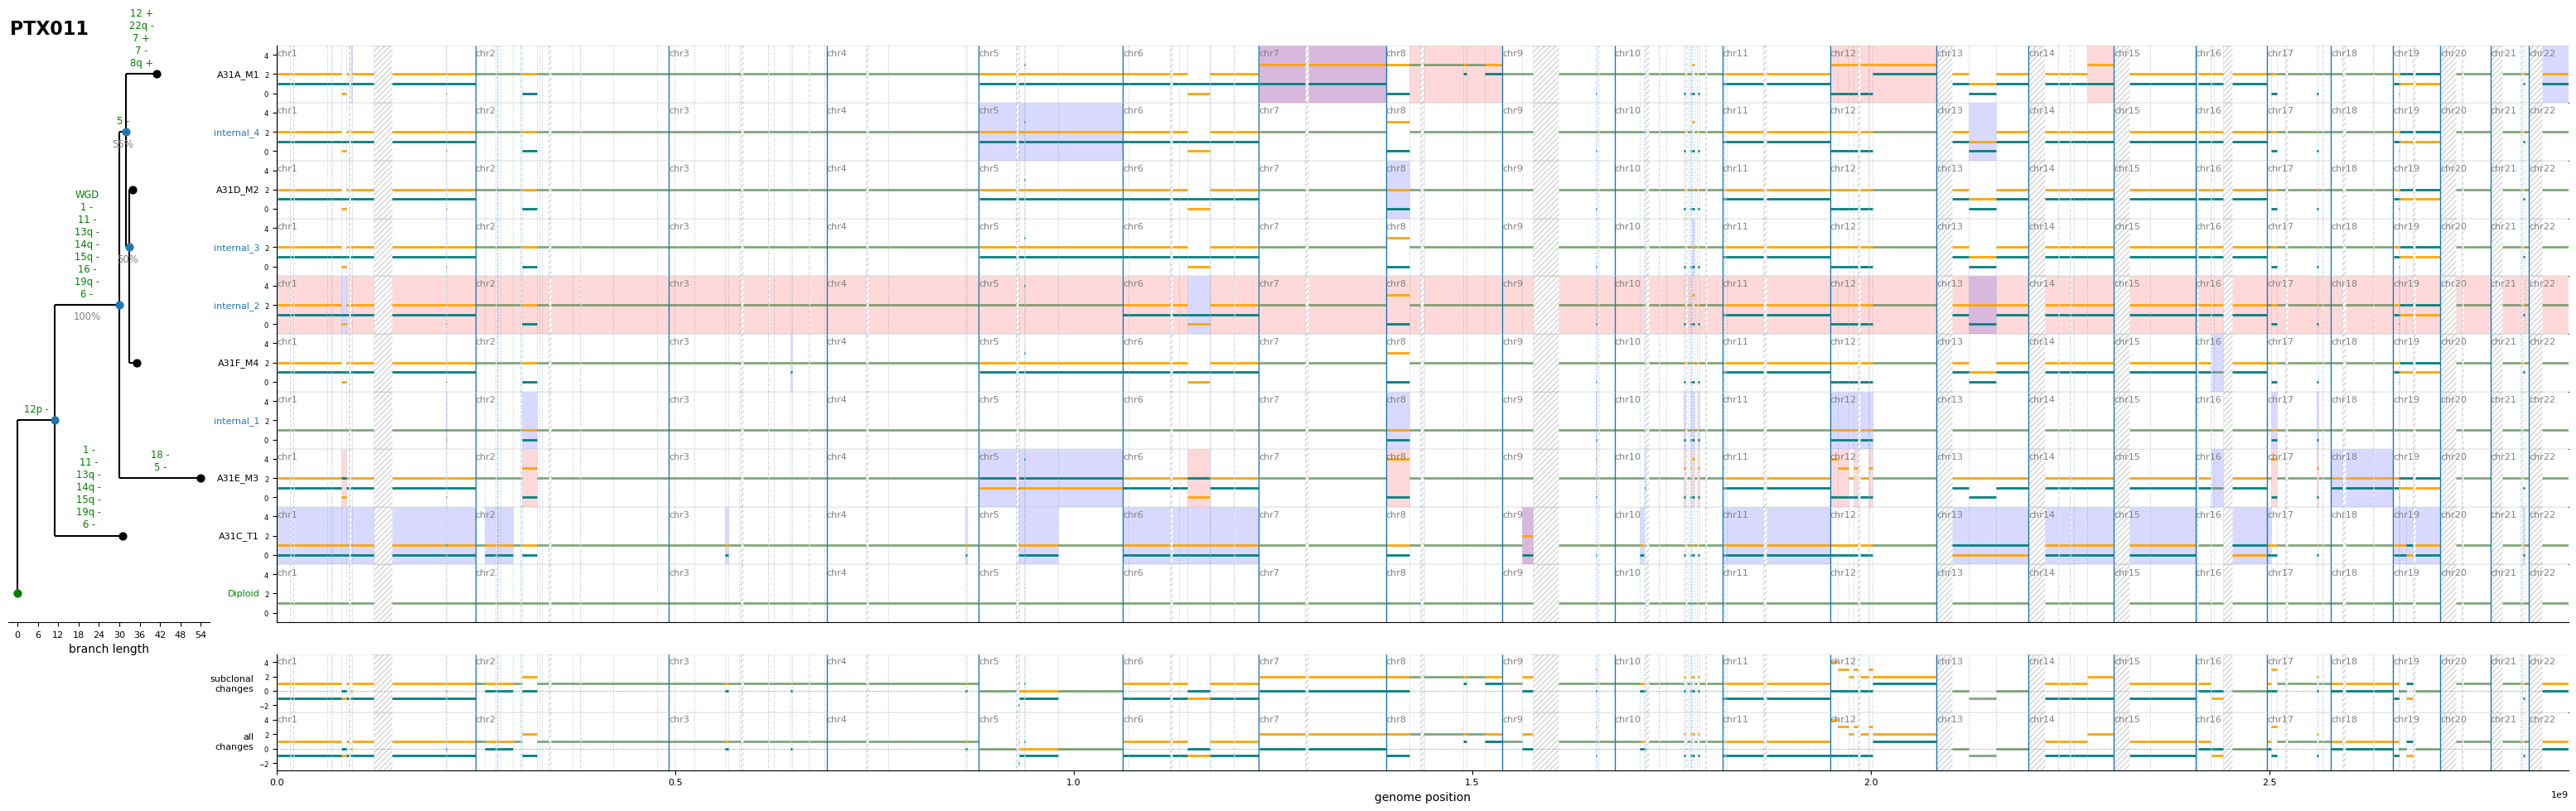

In [8]:
labels = {'diploid': 'Diploid'}
for label in cur_output_df.reset_index()['sample_id']:
    if 'diploid' not in label and 'internal' not in label:
        labels[label] = '_'.join([label.split('_')[1].split('-')[0], label.split('_')[-1]])

fig = medicc.plot.plot_cn_profiles(
    cur_output_df,
    support_tree,
    title=patient,
    normal_name='diploid',
    hide_normal_chromosomes=False,
    show_branch_support=True,
    show_branch_lengths=False,
    show_events_in_tree=True,
    ignore_segment_lengths=False,
    horizontal_margin_adjustment=0.0,
    label_func=lambda label: labels.get(label, label))

for ax in fig.get_axes():
    ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment='right')


# Basic CN tracks for all patients

Plotting CN track for patient PTX008


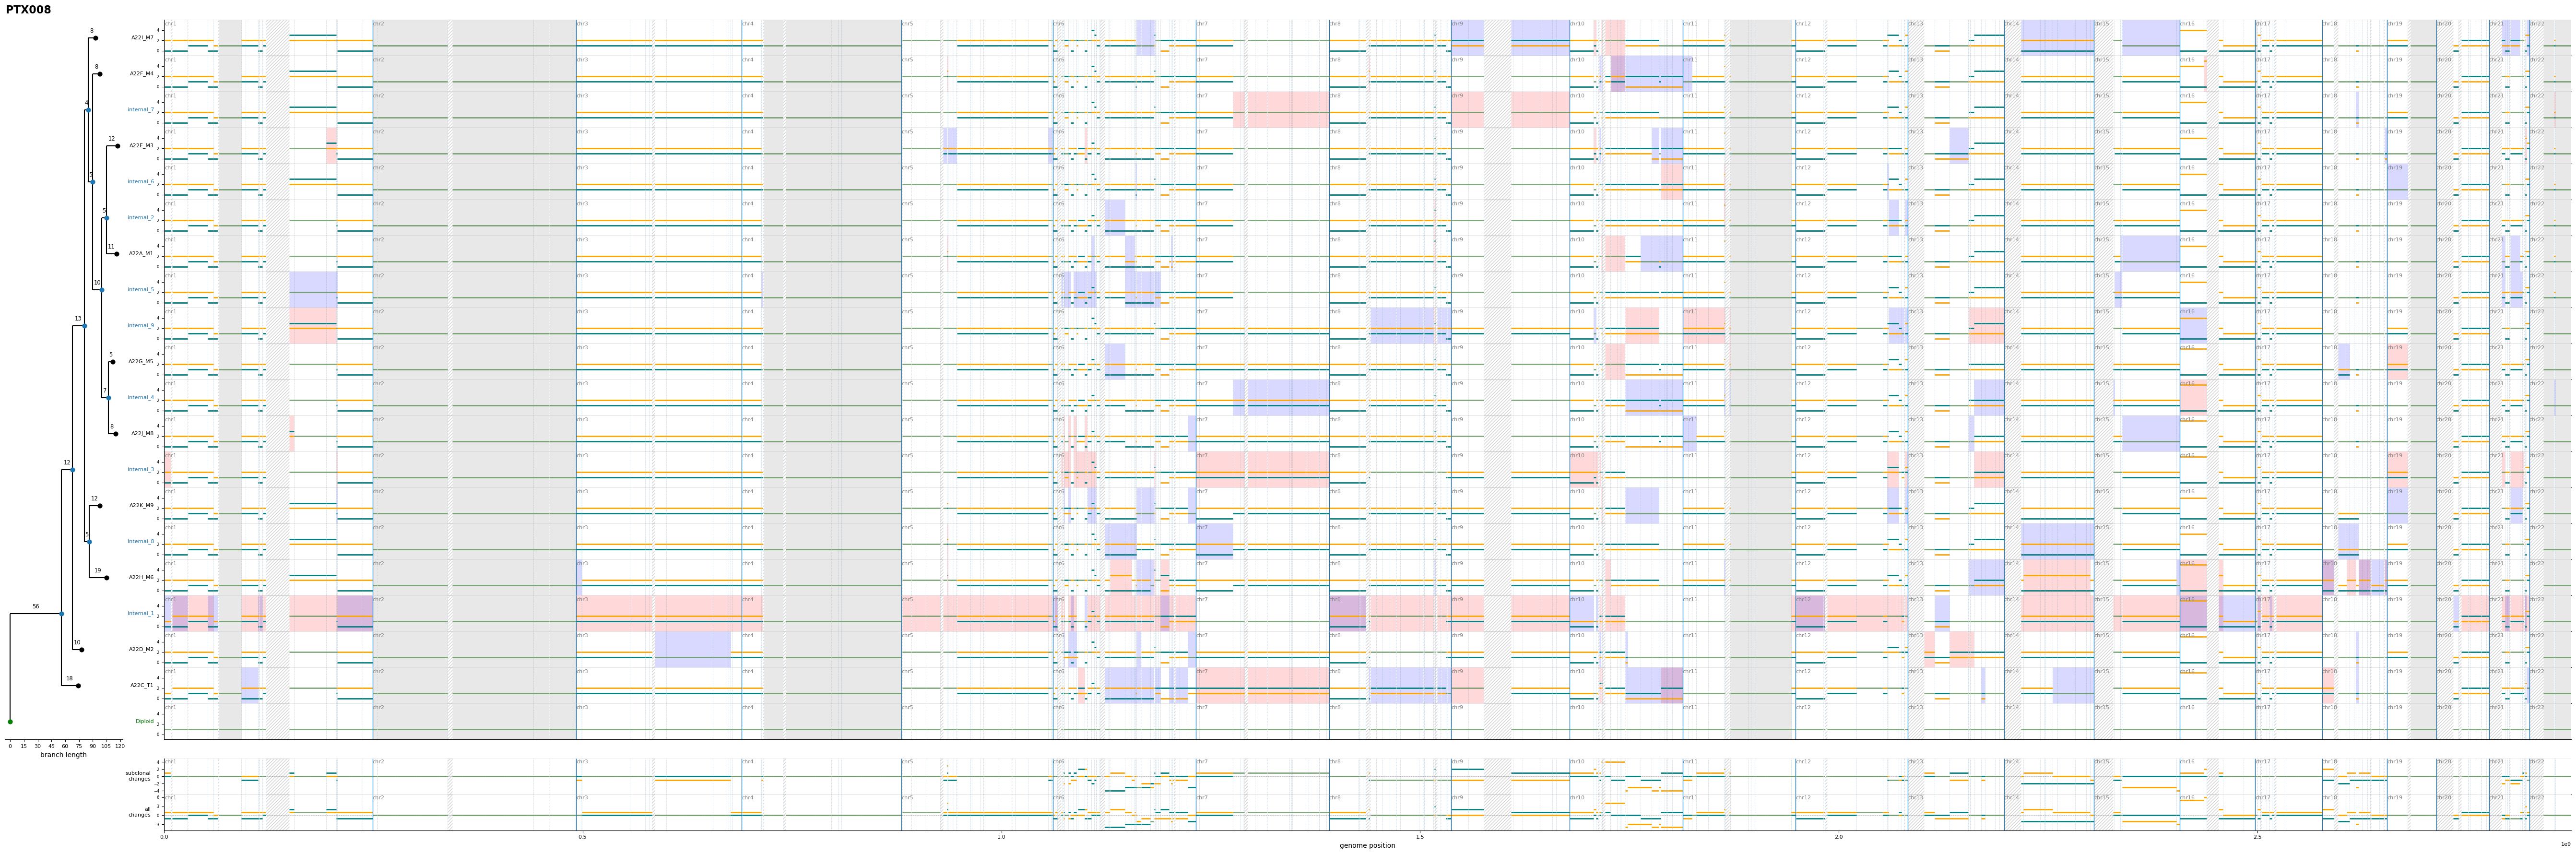

In [9]:
# for patient in patients:
for patient in ['PTX008']:
    print('Plotting CN track for patient {}'.format(patient))
    cur_output_df = medicc.io.read_and_parse_input_data(
        os.path.join(results_folder, "{}_final_cn_profiles.tsv".format(patient)))
    cur_tree = medicc.io.import_tree(
        os.path.join(results_folder, "{}_final_tree.new".format(patient)), 'diploid')

    labels = {'diploid': 'Diploid'}
    for label in cur_output_df.reset_index()['sample_id']:
        if 'diploid' not in label and 'internal' not in label:
            labels[label] = '_'.join([label.split('_')[1].split('-')[0], label.split('_')[-1]])

    fig = medicc.plot.plot_cn_profiles(
        cur_output_df,
        cur_tree,
        title=patient,
        normal_name='diploid',
        hide_normal_chromosomes=False,
        ignore_segment_lengths=False,
        label_func=lambda label: labels.get(label, label))

    for ax in fig.get_axes():
        ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment='right')